# 5.2 Training a convnet from scratch on a small dataset

Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. A “few” samples can mean anywhere from a few hundred to a
few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats, in a dataset containing 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). We’ll use 2,000 pictures for training—1,000 for validation, and 1,000 for testing.

 In this section, we’ll review one basic strategy to tackle this problem: training a new model from scratch using what little data you have. You’ll start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. This will get you to a classification accuracy of 71%. At that point, the main issue will be overfitting. Then we’ll introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By using data augmentation, you’ll improve the network to reach an accuracy of 82%.
 
 In the next section, we’ll review two more essential techniques for applying deep
learning to small datasets: *feature extraction with a pretrained network* (which will get you to an accuracy of 90% to 96%) and *fine-tuning a pretrained network* (this will get you to a final accuracy of 97%). Together, these three strategies—training a small model from scratch, doing feature extraction using a pretrained model, and fine-tuning a pretrained model—will constitute your future toolbox for tackling the problem of performing image classification with small datasets.

## 5.2.1 The relevance of deep learning for small-data problems

You’ll sometimes hear that deep learning only works when lots of data is available.
This is valid in part: one fundamental characteristic of deep learning is that it can find
interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are
available. This is especially true for problems where the input samples are very highdimensional, like images.

 But what constitutes lots of samples is relative—relative to the size and depth of the
network you’re trying to train, for starters. It isn’t possible to train a convnet to solve a
complex problem with just a few tens of samples, but a few hundred can potentially
suffice if the model is small and well regularized and the task is simple. Because convnets learn local, translation-invariant features, they’re highly data efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still
yield reasonable results despite a relative lack of data, without the need for any custom
feature engineering. You’ll see this in action in this section.

 What’s more, deep-learning models are by nature highly repurposable: you can
take, say, an image-classification or speech-to-text model trained on a large-scale dataset
and reuse it on a significantly different problem with only minor changes. Specifically, in the case of computer vision, many pretrained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. That’s what you’ll do in the next section. Let’s
start by getting your hands on the data.

## 5.2.2 Downloading the data

The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when
convnets weren’t mainstream. You can download the original dataset from www.kaggle.com/c/dogs-vs-cats/data (you’ll need to create a Kaggle account if you don’t already
have one—don’t worry, the process is painless).

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and
is 543 MB (compressed). After downloading and uncompressing it, you’ll create a new
dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 500 samples of each class.

### *Copying images to training, validation, and test directories*

In [1]:
import os, shutil

#Path to the directory where the original dataset was uncompressed
original_dataset_dir = '/kaggle/input/dogs-vs-cats/train/train'

# Directory where you'll store your smaller dataset
base_dir = '/kaggle/working/cats_and_dogs_small'
os.mkdir(base_dir)

# Directories for the training, validation, and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directories with training cat pictures and dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directories with validation cat pictures and dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directories with test cat pictures and dog pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copies the first 1000 cat images to train_cat_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copies the next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copies the next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copies the first 1,000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copies the next 500 dog images to validation_dogs_dir    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copies the next 500 dog images to test_dogs_dir  
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

So you do indeed have 2,000 training images, 1,000 validation images, and 1,000 test
images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an
appropriate measure of success. 

In [2]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## 5.2.3 Building your network

You’ll reuse the same general structure: the convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers. But because you’re dealing with bigger images and a more complex problem, you’ll make your network larger, accordingly: it will have one more `Conv2D + MaxPooling2D` stage. This serves both to augment the capacity of the network and to further reduce the size of the feature maps so they aren’t overly large when you reach the `Flatten` layer. Here, because you start from inputs of size 150 × 150 (a somewhat arbitrary choice), you end up with feature maps of size 7 × 7 just before the `Flatten` layer.

<div class="alert alert-block alert-info">
The depth of the feature maps progressively increases in the network
(from 32 to 128), whereas the size of the feature maps decreases (from 148 ×
148 to 7 × 7). This is a pattern you’ll see in almost all convnets.
</div>

Because you’re attacking a binary-classification problem, you’ll end the network with a
single unit (a `Dens`e layer of size 1) and a `sigmoid` activation. This unit will encode the
probability that the network is looking at one class or the other.

### *Instantiating a small convnet for dogs vs. cats classification*

In [4]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### *Configuring the model for training*

In [5]:
from keras import optimizers
model.compile(loss='binary_crossentropy', \
              optimizer=optimizers.RMSprop(learning_rate=1e-4), \
              metrics=['acc'])

## 5.2.4 Data preprocessing

As you know by now, data should be formatted into appropriately preprocessed floatingpoint tensors before being fed into the network. Currently, the data sits on a drive as
JPEG files, so the steps for getting it into the network are roughly as follows:
1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know,
neural networks prefer to deal with small input values).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these
steps automatically. Keras has a module with image-processing helper tools, located at
`keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator`,
which lets you quickly set up Python generators that can automatically turn image files
on disk into batches of preprocessed tensors. This is what you’ll use here.

### *Using `ImageDataGenerator` to read images from directories*

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=20, 
                                                    class_mode='binary')
# train_dir: target directory 
# resizes all images to target_size
# class_mode='binary': because you use binary_classification, you need binary labels

validation_generator = test_datagen.flow_from_directory(validation_dir, 
                                                        target_size=(150, 150), 
                                                        batch_size=20, 
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


*Understanding Python generators*

A Python generator is an object that acts as an iterator: it’s an object you can use with the `for … in` operator. Generators are built using the yield operator. Here is an example of a generator that yields integers:

```python
def generator():
    i=0
    while True:
        i += 1
        yield i
        
for item in generator():`
    print(item)
    if item > 4:
        break
```
It prints this:
```python
1
2
3
4
5
```

Let’s look at the output of one of these generators: it yields batches of 150 × 150 RGB
images (shape `(20, 150, 150, 3)`) and binary labels (shape `(20,)`). There are 20 samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need
to `break` the iteration loop at some point:

In [7]:
for data_batch, labels_batch in train_generator:
    print('data batch shape', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape (20, 150, 150, 3)
labels batch shape: (20,)


Let’s fit the model to the data using the generator. You do so using the `fit_generator`
method, the equivalent of `fit` for data generators like this one. It expects as its first
argument a Python generator that will yield batches of inputs and targets indefinitely,
like this one does. Because the data is being generated endlessly, the Keras model
needs to know how many samples to draw from the generator before declaring an
epoch over. This is the role of the `steps_per_epoch` argument: after having drawn
`steps_per_epoch` batches from the generator—that is, after having run for `steps_per_epoch` gradient descent steps—the fitting process will go to the next
epoch. In this case, batches are 20 samples, so it will take 100 batches until you see
your target of 2,000 samples.

 When using `fit_generator`, you can pass a `validation_data` argument, much as
with the `fit` method. It’s important to note that this argument is allowed to be a data
generator, but it could also be a tuple of Numpy arrays. If you pass a generator as
`validation_data`, then this generator is expected to yield batches of validation data
endlessly; thus you should also specify the `validation_steps` argument, which tells
the process how many batches to draw from the validation generator for evaluation.

Update: `Model.fit_generator` is deprecated, let's use `Model.fit`, which supports generators.

### *Fitting the model using a batch generator*

In [9]:
history = model.fit(
    train_generator, 
    steps_per_epoch=100, 
    epochs=30, 
    validation_data=validation_generator, 
    validation_steps=30)

Epoch 1/30
100/100 [==============================] - 5s 51ms/step - loss: 0.6907 - acc: 0.5380 - val_loss: 0.6688 - val_acc: 0.5717
Epoch 2/30
100/100 [==============================] - 5s 47ms/step - loss: 0.6511 - acc: 0.6055 - val_loss: 0.6304 - val_acc: 0.6650
Epoch 3/30
100/100 [==============================] - 4s 44ms/step - loss: 0.5973 - acc: 0.6885 - val_loss: 0.6113 - val_acc: 0.6600
Epoch 4/30
100/100 [==============================] - 5s 47ms/step - loss: 0.5569 - acc: 0.6925 - val_loss: 0.6161 - val_acc: 0.6517
Epoch 5/30
100/100 [==============================] - 4s 45ms/step - loss: 0.5257 - acc: 0.7370 - val_loss: 0.6102 - val_acc: 0.6617
Epoch 6/30
100/100 [==============================] - 5s 54ms/step - loss: 0.5036 - acc: 0.7480 - val_loss: 0.5902 - val_acc: 0.6817
Epoch 7/30
100/100 [==============================] - 5s 45ms/step - loss: 0.4762 - acc: 0.7745 - val_loss: 0.5886 - val_acc: 0.6950
Epoch 8/30
100/100 [==============================] - 5s 48ms/step - 

### *Saving the model*

In [14]:
model.save('cats_and_dogs_small_1.h5')

### *Displaying curves of loss and accuracy during training*

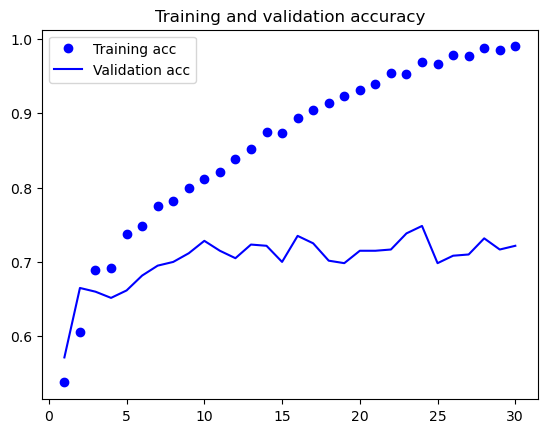

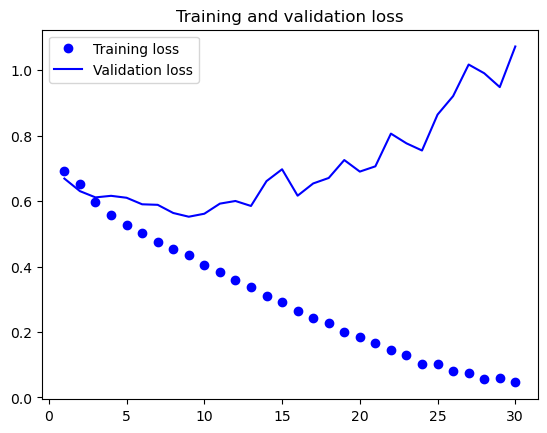

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly
over time, until it reaches nearly 100%, whereas the validation accuracy stalls at 70–72%.
The validation loss reaches its minimum after only five epochs and then stalls, whereas
the training loss keeps decreasing linearly until it reaches nearly 0.
 Because you have relatively few training samples (2,000), overfitting will be your
number-one concern. You already know about a number of techniques that can help
mitigate overfitting, such as dropout and weight decay (L2 regularization). In the next section, we will work with a new one, specific to computer vision and used almost universally
when processing images with deep-learning models: *data augmentation*. 

## 5.2.5 Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable
to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would
never overfit. Data augmentation takes the approach of generating more training data
from existing training samples, by *augmenting* the samples via a number of random
transformations that yield believable-looking images. The goal is that at training time,
your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data and generalize better.

 In Keras, this can be done by configuring a number of random transformations to
be performed on the images read by the `ImageDataGenerator` instance. Let’s get
started with an example.

### *Setting up a data augmentation configuration via `ImageDataGenerator`*

In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation).
Let’s quickly go over this code:
- `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half the images horizontally—relevant when there are no assumptions of horizontal asymmetry (for example, real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let’s look at the augmented images.

### *Displaying some randomly augmented training images*

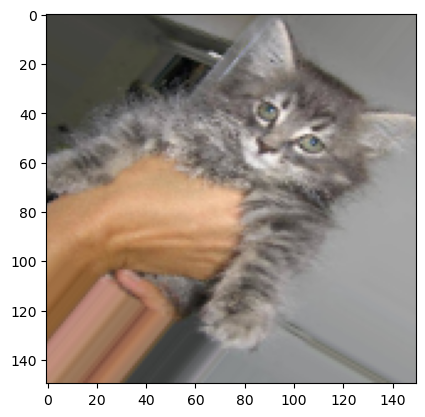

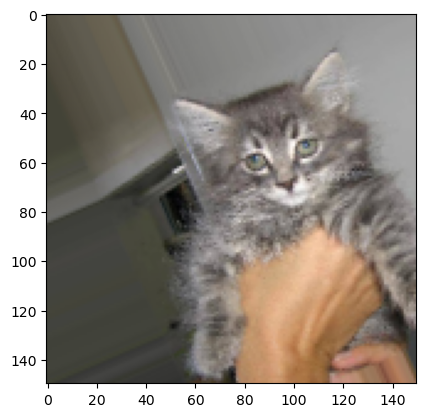

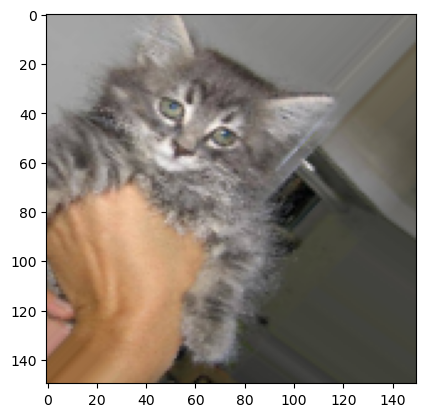

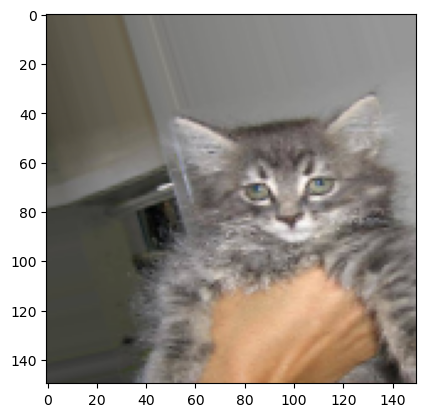

In [18]:
# Module with image-preprocessing utilities
import keras.utils as image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# Chooses one image to augment
img_path = fnames[5]
# Reads the image and resizes it
img = image.load_img(img_path, target_size=(150, 150))
# Converts it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)
# Reshapes it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# Generates batches of randomly transformed images.
# Loops indefinitely, so you need to break the loop at some point.
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If you train a new network using this data-augmentation configuration, the network
will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not
be enough to completely get rid of overfitting. To further fight overfitting, you’ll also
add a `Dropout` layer to your model, right before the densely connected classifier.

### *Defining a new convnet that includes dropout*

In [37]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(learning_rate=1e-4), 
              metrics=['acc'])

### *Training the convnet using data-augmentation generators*

In [38]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data shouldn't be augmented.
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

history = model.fit(
    train_generator,
    steps_per_epoch=2000//32,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=1000//32)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
62/62 [==============================] - 17s 256ms/step - loss: 0.6925 - acc: 0.5295 - val_loss: 0.7032 - val_acc: 0.5050
Epoch 2/100
62/62 [==============================] - 16s 263ms/step - loss: 0.6862 - acc: 0.5356 - val_loss: 0.6722 - val_acc: 0.5675
Epoch 3/100
62/62 [==============================] - 15s 250ms/step - loss: 0.6763 - acc: 0.5808 - val_loss: 0.6602 - val_acc: 0.5847
Epoch 4/100
62/62 [==============================] - 16s 261ms/step - loss: 0.6727 - acc: 0.5737 - val_loss: 0.6681 - val_acc: 0.5796
Epoch 5/100
62/62 [==============================] - 15s 235ms/step - loss: 0.6684 - acc: 0.5833 - val_loss: 0.7770 - val_acc: 0.5030
Epoch 6/100
62/62 [==============================] - 16s 261ms/step - loss: 0.6578 - acc: 0.6006 - val_loss: 0.8859 - val_acc: 0.5010
Epoch 7/100
62/62 [==============================] - 16s 250ms/step - loss: 0.6484 - acc: 0.6169 - val_loss: 0.6

### *Saving the model*

In [39]:
model.save('cats_and_dogs_small_2.h5')

In [40]:
len(history.history['val_acc'])

100

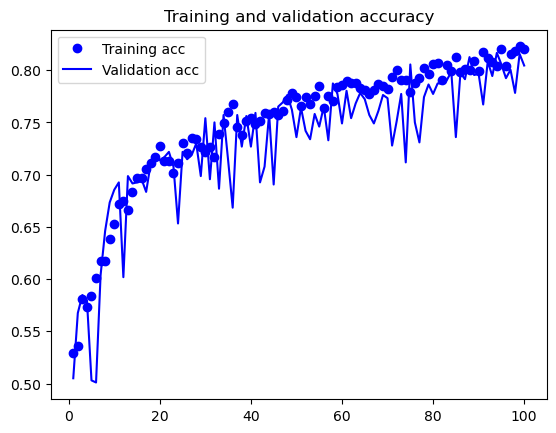

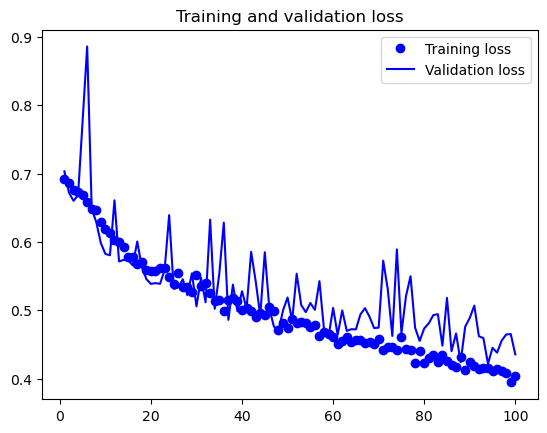

In [41]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

By using regularization techniques even further, and by tuning the network’s parameters (such as the number of filters per convolution layer, or the number of layers in
the network), you may be able to get an even better accuracy, likely up to 86% or 87%.
But it would prove difficult to go any higher just by training your own convnet from
scratch, because you have so little data to work with. As a next step to improve your
accuracy on this problem, you’ll have to use a pretrained model, which is the focus of
the next two sections. 